# Home 4: Build a CNN for image recognition.

### Name: Michael Eng


## 0. You will do the following:

1. Read, complete, and run the code.

2. **Make substantial improvements** to maximize the accurcy.
    
3. Convert the .IPYNB file to .HTML file.

    * The HTML file must contain the code and the output after execution.
    
    * Missing **the output after execution** will not be graded.
    
4. Upload this .HTML file to your Google Drive, Dropbox, or Github repo. (If you submit the file to Google Drive or Dropbox, you must make the file "open-access". The delay caused by "deny of access" may result in late penalty.)

4. Submit the link to this .HTML file to Canvas.

    * Example: https://github.com/wangshusen/CS583-2020S/blob/master/homework/HM4/HM4.html


## Requirements:

1. You can use whatever CNN architecture, including VGG, Inception, and ResNet. However, you must build the networks layer by layer. You must NOT import the archetectures from ```keras.applications```.

2. Make sure ```BatchNormalization``` is between a ```Conv```/```Dense``` layer and an ```activation``` layer.

3. If you want to regularize a ```Conv```/```Dense``` layer, you should place a ```Dropout``` layer **before** the ```Conv```/```Dense``` layer.

4. An accuracy above 70% is considered reasonable. An accuracy above 80% is considered good. Without data augmentation, achieving 80% accuracy is difficult.


## Google Colab

- If you do not have GPU, the training of a CNN can be slow. Google Colab is a good option.

- Keep in mind that you must download it as an IPYNB file and then use IPython Notebook to convert it to HTML.

- Also keep in mind that the IPYNB and HTML files must contain the outputs. (Otherwise, the instructor will not be able to know the correctness and performance.) Do the followings to keep the outputs.

- In Colab, go to ```Runtime``` --> ```Change runtime type``` --> Do NOT check ```Omit code cell output when saving this notebook```. In this way, the downloaded IPYNB file contains the outputs.

## 1. Data preparation

### 1.1. Load data


In [1]:
from tensorflow.keras.datasets import cifar10
import numpy

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

print('shape of x_train: ' + str(x_train.shape))
print('shape of y_train: ' + str(y_train.shape))
print('shape of x_test: ' + str(x_test.shape))
print('shape of y_test: ' + str(y_test.shape))
print('number of classes: ' + str(numpy.max(y_train) - numpy.min(y_train) + 1))

shape of x_train: (50000, 32, 32, 3)
shape of y_train: (50000, 1)
shape of x_test: (10000, 32, 32, 3)
shape of y_test: (10000, 1)
number of classes: 10


### 1.2. One-hot encode the labels

In the input, a label is a scalar in $\{0, 1, \cdots , 9\}$. One-hot encode transform such a scalar to a $10$-dim vector. E.g., a scalar ```y_train[j]=3``` is transformed to the vector ```y_train_vec[j]=[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]```.

1. Define a function ```to_one_hot``` that transforms an $n\times 1$ array to a $n\times 10$ matrix.

2. Apply the function to ```y_train``` and ```y_test```.

In [2]:
def to_one_hot(y, num_class=10):
    res = numpy.zeros((y.shape[0], num_class))
    for i,val in enumerate(y):
        res[i, val] = 1
    return res

y_train_vec = to_one_hot(y_train)
y_test_vec = to_one_hot(y_test)

NUM_CLASSES = 10

print('Shape of y_train_vec: ' + str(y_train_vec.shape))
print('Shape of y_test_vec: ' + str(y_test_vec.shape))

print(y_train[0])
print(y_train_vec[0])

Shape of y_train_vec: (50000, 10)
Shape of y_test_vec: (10000, 10)
[6]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


#### Remark: the outputs should be
* Shape of y_train_vec: (50000, 10)
* Shape of y_test_vec: (10000, 10)
* [6]
* [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]

### 1.3. Randomly partition the training set to training and validation sets

Randomly partition the 50K training samples to 2 sets:
* a training set containing 40K samples
* a validation set containing 10K samples


In [3]:
rand_indices = numpy.random.permutation(50000)
train_indices = rand_indices[0:40000]
valid_indices = rand_indices[40000:50000]

x_val = x_train[valid_indices, :]
y_val = y_train_vec[valid_indices, :]

x_tr = x_train[train_indices, :]
y_tr = y_train_vec[train_indices, :]

print('Shape of x_tr: ' + str(x_tr.shape))
print('Shape of y_tr: ' + str(y_tr.shape))
print('Shape of x_val: ' + str(x_val.shape))
print('Shape of y_val: ' + str(y_val.shape))

Shape of x_tr: (40000, 32, 32, 3)
Shape of y_tr: (40000, 10)
Shape of x_val: (10000, 32, 32, 3)
Shape of y_val: (10000, 10)


## 2. Build a CNN and tune its hyper-parameters

1. Build a convolutional neural network model
2. Use the validation data to tune the hyper-parameters (e.g., network structure, and optimization algorithm)
    * Do NOT use test data for hyper-parameter tuning!!!
3. Try to achieve a validation accuracy as high as possible.

### Remark: 

The following CNN is just an example. You are supposed to make **substantial improvements** such as:
* Add more layers.
* Use regularizations, e.g., dropout.
* Use batch normalization.

In [4]:
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D, AveragePooling2D, Flatten, Dense, Activation, Dropout, ZeroPadding2D, Add, LeakyReLU
from tensorflow.keras import utils, Input, initializers, optimizers
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers

from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, RandomContrast, RandomWidth, RandomZoom

learning_rate = 1E-5 # to be tuned!


def bn_relu(input):
    bn = BatchNormalization(axis=3)(input)
    return Activation('relu')(bn)

def residual_block(x, downsample: bool, filters: int, kernel_size: int = 3):
    y = Conv2D(kernel_size=kernel_size, strides=(1 if not downsample else 2), filters=filters, padding='same')(x)
    y = bn_relu(y)
    y = Conv2D(kernel_size=kernel_size, strides=1, filters=filters, padding='same')(y)
    if downsample:
        x = Conv2D(kernel_size=kernel_size, strides=2, filters=filters, padding='same')(x)
    out = Add()([x,y])
    out = bn_relu(out)
    return out

def build_resnet(dropout = 0.0, num_blocks_list = [2,5,5,2]):
    num_filters = 64
    X_input = Input(shape=(32,32,3))
    X = ZeroPadding2D(padding=(3,3), data_format=None)(X_input)
    X = Conv2D(filters = num_filters, kernel_size=(7,7), strides=(1,1), name = 'conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3,3), strides=(2,2))(X)
    # Stage 2 for ResNet

    for i,blocks in enumerate(num_blocks_list):
        for j in range(blocks):
            X = residual_block(X, downsample=(j==0 and i!=0), filters=num_filters)
        if num_filters < 256:
            num_filters *= 2

    x = AveragePooling2D(pool_size=(4,4), padding='same')(X)
    X = Flatten()(X)
    X = Dropout(dropout)(X)
    X = Dense(num_filters, activation='relu', kernel_initializer=glorot_uniform(seed=0))(X)
    X = Dense(NUM_CLASSES, activation='softmax', name='fc' + str(NUM_CLASSES), kernel_initializer=glorot_uniform(seed=0))(X)
    name = 'ResNetDropOut' + str(int(dropout * 100))
    model = Model(inputs = X_input, outputs = X, name=name)
    return model



### Tune learning rate
The first learning rate attempted is 10^-5, which is then increased to 10^-4 and 10^-3. The best results were with a learning rate of 10^-4 so I tried a learning rate in the middle of 5 * 10^-5. 

The result was as follows:

10^-5
training acc: 0.8596
val acc: 0.4551

5 * 10^-5
acc: 0.9391
val acc: 0.5844

10^-4
training acc: 0.9458
val acc: 0.6327

10^-3
training acc: 0.4317
val acc: 0.3320



In [16]:
model1.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=learning_rate),
              metrics=['acc'])

In [17]:
history = model1.fit(x_tr, y_tr, batch_size=32, epochs=10, validation_data=(x_val, y_val))

Epoch 1/10
1250/1250 [==============================] - 386s 307ms/step - loss: 2.2652 - acc: 0.2045 - val_loss: 1.8775 - val_acc: 0.3286
Epoch 2/10
1250/1250 [==============================] - 381s 305ms/step - loss: 1.7055 - acc: 0.3891 - val_loss: 1.7104 - val_acc: 0.3907
Epoch 3/10
1250/1250 [==============================] - 381s 305ms/step - loss: 1.4359 - acc: 0.4840 - val_loss: 1.6130 - val_acc: 0.4275
Epoch 4/10
1250/1250 [==============================] - 384s 307ms/step - loss: 1.2465 - acc: 0.5562 - val_loss: 1.5921 - val_acc: 0.4432
Epoch 5/10
1250/1250 [==============================] - 397s 317ms/step - loss: 1.0573 - acc: 0.6290 - val_loss: 1.6069 - val_acc: 0.4393
Epoch 6/10
1250/1250 [==============================] - 406s 325ms/step - loss: 0.9151 - acc: 0.6850 - val_loss: 1.6487 - val_acc: 0.4608
Epoch 7/10
1250/1250 [==============================] - 382s 306ms/step - loss: 0.7798 - acc: 0.7374 - val_loss: 1.6957 - val_acc: 0.4540
Epoch 8/10
1250/1250 [============

Learning rate 10^-4

In [19]:
model2 = build_resnet()
model2.summary()

Model: "ResNetDropOut0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d_4 (ZeroPadding2D (None, 38, 38, 3)    0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 32, 64)   9472        zero_padding2d_4[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 32, 32, 64)   256         conv1[0][0]                      
_____________________________________________________________________________________

In [23]:
model2.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=learning_rate * 10),
              metrics=['acc'])
history2 = model2.fit(x_tr, y_tr, batch_size=32, epochs=10, validation_data=(x_val, y_val))

Epoch 1/10
1250/1250 [==============================] - 418s 332ms/step - loss: 1.9542 - acc: 0.3360 - val_loss: 1.3977 - val_acc: 0.5039
Epoch 2/10
1250/1250 [==============================] - 403s 322ms/step - loss: 1.1500 - acc: 0.5894 - val_loss: 1.3436 - val_acc: 0.5520
Epoch 3/10
1250/1250 [==============================] - 402s 322ms/step - loss: 0.8690 - acc: 0.6938 - val_loss: 1.4567 - val_acc: 0.5231
Epoch 4/10
1250/1250 [==============================] - 412s 330ms/step - loss: 0.6522 - acc: 0.7714 - val_loss: 1.3527 - val_acc: 0.5910
Epoch 5/10
1250/1250 [==============================] - 411s 329ms/step - loss: 0.4702 - acc: 0.8390 - val_loss: 1.3161 - val_acc: 0.6123
Epoch 6/10
1250/1250 [==============================] - 427s 342ms/step - loss: 0.3474 - acc: 0.8813 - val_loss: 1.3437 - val_acc: 0.6467
Epoch 7/10
1250/1250 [==============================] - 427s 342ms/step - loss: 0.2664 - acc: 0.9107 - val_loss: 1.1913 - val_acc: 0.6683
Epoch 8/10
1250/1250 [============

Learning rate 10^-3

In [21]:
model3 = build_resnet()
model3.summary()

Model: "ResNetDropOut0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d_5 (ZeroPadding2D (None, 38, 38, 3)    0           input_6[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 32, 64)   9472        zero_padding2d_5[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 32, 32, 64)   256         conv1[0][0]                      
_____________________________________________________________________________________

In [24]:
model3.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=learning_rate * 100),
              metrics=['acc'])
history3 = model3.fit(x_tr, y_tr, batch_size=32, epochs=10, validation_data=(x_val, y_val))

Epoch 1/10
1250/1250 [==============================] - 421s 335ms/step - loss: 2.5958 - acc: 0.1303 - val_loss: 9.7224 - val_acc: 0.1114
Epoch 2/10
1250/1250 [==============================] - 411s 329ms/step - loss: 2.0030 - acc: 0.2344 - val_loss: 10.5875 - val_acc: 0.1604
Epoch 3/10
1250/1250 [==============================] - 388s 310ms/step - loss: 2.0408 - acc: 0.2338 - val_loss: 47.4849 - val_acc: 0.1672
Epoch 4/10
1250/1250 [==============================] - 388s 310ms/step - loss: 1.9013 - acc: 0.2690 - val_loss: 2.9498 - val_acc: 0.1987
Epoch 5/10
1250/1250 [==============================] - 390s 312ms/step - loss: 1.8471 - acc: 0.2935 - val_loss: 6.0383 - val_acc: 0.2178
Epoch 6/10
1250/1250 [==============================] - 405s 324ms/step - loss: 1.7885 - acc: 0.3022 - val_loss: 2.6981 - val_acc: 0.1773
Epoch 7/10
1250/1250 [==============================] - 401s 321ms/step - loss: 1.7378 - acc: 0.3256 - val_loss: 3.6083 - val_acc: 0.2145
Epoch 8/10
1250/1250 [==========

Learning rate 5 * 10^-5

In [31]:
model4 = build_resnet()
model4.summary()

Model: "ResNetDropOut0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d_8 (ZeroPadding2D (None, 38, 38, 3)    0           input_9[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 32, 64)   9472        zero_padding2d_8[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 32, 32, 64)   256         conv1[0][0]                      
_____________________________________________________________________________________

In [32]:
model4.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=learning_rate * 5),
              metrics=['acc'])
history4 = model4.fit(x_tr, y_tr, batch_size=32, epochs=10, validation_data=(x_val, y_val))

Epoch 1/10
1250/1250 [==============================] - 219s 173ms/step - loss: 2.0283 - acc: 0.2853 - val_loss: 1.5359 - val_acc: 0.4525
Epoch 2/10
1250/1250 [==============================] - 219s 175ms/step - loss: 1.3083 - acc: 0.5265 - val_loss: 1.3959 - val_acc: 0.5006
Epoch 3/10
1250/1250 [==============================] - 227s 182ms/step - loss: 1.0160 - acc: 0.6349 - val_loss: 1.3096 - val_acc: 0.5482
Epoch 4/10
1250/1250 [==============================] - 225s 180ms/step - loss: 0.7646 - acc: 0.7309 - val_loss: 1.3223 - val_acc: 0.5722
Epoch 5/10
1250/1250 [==============================] - 219s 175ms/step - loss: 0.5400 - acc: 0.8113 - val_loss: 1.3709 - val_acc: 0.5899
Epoch 6/10
1250/1250 [==============================] - 218s 175ms/step - loss: 0.3680 - acc: 0.8714 - val_loss: 1.7314 - val_acc: 0.5652
Epoch 7/10
1250/1250 [==============================] - 217s 174ms/step - loss: 0.2715 - acc: 0.9062 - val_loss: 1.8190 - val_acc: 0.5739
Epoch 8/10
1250/1250 [============

### Add Dropout

Adding dropout increased the validation accuracy and decreased the training accuracy, but the model is still overfit. Next I will add data augmentation.

10^-4 
training acc: 0.9458 
val acc: 0.6327

10^-4 with dropout
training acc: 0.8292 
val acc: 0.7092

In [40]:
model5 = build_resnet(0.5)
model5.summary()

Model: "ResNetDropOut50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d_26 (ZeroPadding2 (None, 38, 38, 3)    0           input_14[0][0]                   
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 32, 64)   9472        zero_padding2d_26[0][0]          
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 32, 32, 64)   256         conv1[0][0]                      
____________________________________________________________________________________

In [41]:
model5.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=learning_rate * 10),
              metrics=['acc'])
history5 = model5.fit(x_tr, y_tr, batch_size=32, epochs=10, validation_data=(x_val, y_val))

Epoch 1/10
1250/1250 [==============================] - 433s 346ms/step - loss: 0.7172 - acc: 0.7544 - val_loss: 1.1310 - val_acc: 0.6168
Epoch 2/10
1250/1250 [==============================] - 427s 342ms/step - loss: 0.7079 - acc: 0.7628 - val_loss: 3.0078 - val_acc: 0.6635
Epoch 3/10
1250/1250 [==============================] - 419s 335ms/step - loss: 0.6858 - acc: 0.7673 - val_loss: 3.0673 - val_acc: 0.6018
Epoch 4/10
1250/1250 [==============================] - 435s 348ms/step - loss: 0.6571 - acc: 0.7814 - val_loss: 3.9690 - val_acc: 0.6992
Epoch 5/10
1250/1250 [==============================] - 438s 351ms/step - loss: 0.6365 - acc: 0.7857 - val_loss: 0.9552 - val_acc: 0.7129
Epoch 6/10
1250/1250 [==============================] - 429s 343ms/step - loss: 0.6192 - acc: 0.7962 - val_loss: 1.4254 - val_acc: 0.6107
Epoch 7/10
1250/1250 [==============================] - 441s 353ms/step - loss: 0.5939 - acc: 0.8047 - val_loss: 1.0457 - val_acc: 0.7004
Epoch 8/10
1250/1250 [============

### Data Augmentation

First I reduced the number of convolutions to reduce the time it takes to run the network.
The result was:
acc: 0.9528
val acc: 0.6719

Data augmentation is implemented using ImageDataGenerator and the following networks run with this augmented data.

I tried to make a smaller network since the current one takes way to long to train, but it was not as good even with data augmentation.
After 20 epochs:
acc: 0.5664
val acc: 0.6481

Since I dont have time to play around with this smaller network, I plan on fixing the hyper-parameters after the due-date of the assignment for personal gain.

Going back to the larger, resnet based network, I noticed a that the dropout layer was right before the only Dense layer. To fix this, I added another Dense layer, making sure to move the dropout layer to before that layer as well. I ran this network for 50 epochs and the result is:
acc: 0.8265
val_acc: 0.7688

Although this is a notible improvement, and the network is not as overfitted as the past networks, there is still work to be done. I believe the main problem is that there are too many parameters for the reletively small training set. This 18 layer network with over 3 million parameters is way to complex for the 40,000 training samples. The smaller 6 layer network with only a quarter of a million parameters should be a lot closer in complexity for the 40,000 training samples. 

In [12]:
model6 = build_resnet(dropout=0.5, num_blocks_list=[2,2,1,1])
model6.summary()

Model: "ResNetDropOut50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d_4 (ZeroPadding2D (None, 38, 38, 3)    0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 32, 64)   9472        zero_padding2d_4[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 32, 32, 64)   256         conv1[0][0]                      
____________________________________________________________________________________

In [13]:
model6.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=learning_rate * 10),
              metrics=['acc'])
history6 = model6.fit(x_tr, y_tr, batch_size=32, epochs=10, validation_data=(x_val, y_val))

Epoch 1/10
1250/1250 [==============================] - 120s 95ms/step - loss: 1.9604 - acc: 0.3428 - val_loss: 1.4327 - val_acc: 0.5089
Epoch 2/10
1250/1250 [==============================] - 115s 92ms/step - loss: 1.1807 - acc: 0.5881 - val_loss: 1.3576 - val_acc: 0.5348
Epoch 3/10
1250/1250 [==============================] - 115s 92ms/step - loss: 0.8744 - acc: 0.6929 - val_loss: 1.1988 - val_acc: 0.6196
Epoch 4/10
1250/1250 [==============================] - 115s 92ms/step - loss: 0.6442 - acc: 0.7755 - val_loss: 1.4256 - val_acc: 0.5812
Epoch 5/10
1250/1250 [==============================] - 115s 92ms/step - loss: 0.4552 - acc: 0.8429 - val_loss: 1.3442 - val_acc: 0.6188
Epoch 6/10
1250/1250 [==============================] - 115s 92ms/step - loss: 0.3133 - acc: 0.8928 - val_loss: 1.6278 - val_acc: 0.6336
Epoch 7/10
1250/1250 [==============================] - 125s 100ms/step - loss: 0.2352 - acc: 0.9185 - val_loss: 1.2669 - val_acc: 0.6825
Epoch 8/10
1250/1250 [==================

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)
datagen.fit(x_tr, augment=True)

val_gen = ImageDataGenerator()


In [6]:
def build_small_cnn(num_classes=10,dropout = 0.0):
    X_input = Input(shape=(32,32,3))
    
#             layers.experimental.preprocessing.Sequential([RandomFlip('horizontal'),
#             layers.experimental.preprocessing.RandomRotation(20),
#             layers.experimental.preprocessing.RandomContrast(factor=0.2),
#             layers.experimental.preprocessing.RandomWidth(0.2),
#             layers.experimental.preprocessing.RandomZoom(0.2),

    X = Conv2D(filters = 64, kernel_size=(7,7), strides=(1,1), name = 'conv1', kernel_initializer=glorot_uniform(seed=0))(X_input)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)

    X = Conv2D(64, 3)(X_input)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    X = Conv2D(64, 3)(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3,3))(X)
    X = Conv2D(128, 3)(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    X = Conv2D(128, 3)(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    X = AveragePooling2D((4,4))(X)
    X = Flatten()(X)
    X = Dropout(dropout)(X)
    X = Dense(128, activation='relu', kernel_initializer=glorot_uniform(seed=0))(X)
    X = Dense(num_classes, activation='softmax', kernel_initializer=glorot_uniform(seed=0))(X)
    model = Model(inputs = X_input, outputs = X)
    return model

In [8]:
model7 = build_small_cnn(dropout=0.5)
batch_size = 128
print(model7.summary())
model7.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=learning_rate * 10),
              metrics=['acc'])
history7 = model7.fit(datagen.flow(x_tr, y_tr, batch_size=batch_size), epochs=20, steps_per_epoch=x_tr.shape[0]//batch_size, validation_steps=x_val.shape[0]//batch_size, validation_data=val_gen.flow(x_val, y_val, batch_size=batch_size))

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 30, 30, 64)        1792      
_________________________________________________________________
batch_normalization_6 (Batch (None, 30, 30, 64)        256       
_________________________________________________________________
activation_6 (Activation)    (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 64)        36928     
_________________________________________________________________
batch_normalization_7 (Batch (None, 28, 28, 64)        256       
_________________________________________________________________
activation_7 (Activation)    (None, 28, 28, 64)        0   

In [8]:
batch_size = 128

model9 = build_resnet(dropout=0.5, num_blocks_list=[2,2,1,1])
model9.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=learning_rate * 10),
              metrics=['acc'])
history9 = model9.fit(datagen.flow(x_tr, y_tr, batch_size=batch_size), epochs=50, steps_per_epoch=x_tr.shape[0]//batch_size, validation_steps=x_val.shape[0]//batch_size, validation_data=val_gen.flow(x_val, y_val, batch_size=batch_size))

Epoch 1/50
312/312 [==============================] - 112s 353ms/step - loss: 2.1232 - acc: 0.2442 - val_loss: 1.6552 - val_acc: 0.3810
Epoch 2/50
312/312 [==============================] - 114s 363ms/step - loss: 1.6274 - acc: 0.4050 - val_loss: 1.4526 - val_acc: 0.4876
Epoch 3/50
312/312 [==============================] - 111s 356ms/step - loss: 1.4805 - acc: 0.4623 - val_loss: 1.3585 - val_acc: 0.5080
Epoch 4/50
312/312 [==============================] - 111s 357ms/step - loss: 1.3855 - acc: 0.4945 - val_loss: 1.3508 - val_acc: 0.5138
Epoch 5/50
312/312 [==============================] - 111s 357ms/step - loss: 1.3072 - acc: 0.5266 - val_loss: 1.2143 - val_acc: 0.5791
Epoch 6/50
312/312 [==============================] - 112s 357ms/step - loss: 1.2387 - acc: 0.5559 - val_loss: 1.1047 - val_acc: 0.6099
Epoch 7/50
312/312 [==============================] - 111s 357ms/step - loss: 1.1794 - acc: 0.5793 - val_loss: 1.3246 - val_acc: 0.5360
Epoch 8/50
312/312 [============================

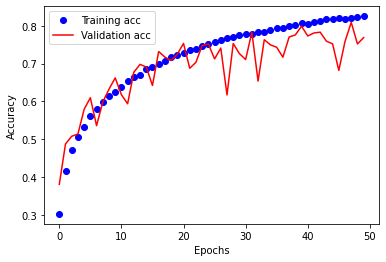

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

acc = history9.history['acc']
val_acc = history9.history['val_acc']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## 3. Train (again) and evaluate the model

- To this end, you have found the "best" hyper-parameters. 
- Now, fix the hyper-parameters and train the network on the entire training set (all the 50K training samples)
- Evaluate your model on the test set.

### 3.1. Train the model on the entire training set

Why? Previously, you used 40K samples for training; you wasted 10K samples for the sake of hyper-parameter tuning. Now you already know the hyper-parameters, so why not using all the 50K samples for training?

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen_ad = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)
datagen_ad.fit(x_train, augment=True)


batch_size = 128

model_all_data = build_resnet(dropout=0.5, num_blocks_list=[2,2,1,1])
model_all_data.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=learning_rate * 10),
              metrics=['acc'])
history_all_data = model_all_data.fit(datagen_ad.flow(x_train,y_train_vec, batch_size=batch_size), epochs=50, steps_per_epoch=x_tr.shape[0]//batch_size)

Epoch 1/50
312/312 [==============================] - 102s 321ms/step - loss: 2.1156 - acc: 0.2501
Epoch 2/50
312/312 [==============================] - 100s 321ms/step - loss: 1.6328 - acc: 0.4024
Epoch 3/50
312/312 [==============================] - 99s 318ms/step - loss: 1.4951 - acc: 0.4551
Epoch 4/50
312/312 [==============================] - 100s 321ms/step - loss: 1.3957 - acc: 0.4928
Epoch 5/50
312/312 [==============================] - 102s 328ms/step - loss: 1.2909 - acc: 0.5366
Epoch 6/50
312/312 [==============================] - 103s 329ms/step - loss: 1.2370 - acc: 0.5575
Epoch 7/50
312/312 [==============================] - 105s 335ms/step - loss: 1.1887 - acc: 0.5764
Epoch 8/50
312/312 [==============================] - 100s 322ms/step - loss: 1.1459 - acc: 0.5912
Epoch 9/50
312/312 [==============================] - 100s 322ms/step - loss: 1.0983 - acc: 0.6091
Epoch 10/50
312/312 [==============================] - 100s 320ms/step - loss: 1.0518 - acc: 0.6278
Epoch 11/5

### 3.2. Evaluate the model on the test set

Do NOT used the test set until now. Make sure that your model parameters and hyper-parameters are independent of the test set.

In [11]:
loss_and_acc = model_all_data.evaluate(x_test, y_test_vec)
print('loss = ' + str(loss_and_acc[0]))
print('accuracy = ' + str(loss_and_acc[1]))

313/313 [==============================] - 6s 18ms/step - loss: 0.8377 - acc: 0.7545
loss = 0.837701678276062
accuracy = 0.7544999718666077
